In [115]:
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from biosppy.signals import ecg
from sklearn import metrics
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [117]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set filepath
filepath = 'PTB_processed_new'
total = len(os.listdir(filepath))

# Load label file
labels_file = pd.read_csv("new_labels.csv", header=0)
labels = np.asarray(labels_file['diagnosis'])

# Create empty containers
signal_array = []  # To store all segments
label_array = []   # To store all labels

# Create counters
files_completed = 0
file_number = 0

In [118]:
# Signal Extractor
start_time = time.time()
for filename in os.listdir(filepath):
    start_time_file = time.time()
    data = pd.read_csv(os.path.join(filepath, filename), header=0, engine='python')
    file_label = labels[file_number]
    col_names = ['v1', 'v2', 'v3', 'v4', 'v5', 'v6'] # Columns used

    # Compute peaks based on V4 (or alternatively, use an averaged signal)
    peaks = ecg.christov_segmenter(np.array(data['v4']), 1000)[0]

    for peak in range(1, len(peaks) - 1):
        segment_array = []  # To store one segment

        # Extract segment for each column
        for col in data: # Replace data with col_names to only use specific columns
            segment = np.array(data[col])[peaks[peak] - 50:peaks[peak] + 100]  # Extract segment
            segment_array.append(segment)

        signal_array.append(segment_array)
        label_array.append(file_label)

    files_completed += 1
    file_number += 1
    progress = round(files_completed / total * 100, 2)
    end_time_file = time.time()
    elapsed_time_file = round(end_time_file - start_time_file, 2)
    sys.stdout.write(f'\r{filename} loaded - {progress}% completed - Took: {elapsed_time_file} seconds')


signal_array = np.asarray(signal_array)
end_time = time.time()
elapsed_time = round(end_time - start_time, 2)
print(f'\nData loading completed: {files_completed} files - Took: {elapsed_time} seconds')

le = preprocessing.LabelEncoder()
data_labels = le.fit_transform(label_array)
num_classes = le.classes_.size
print(le.classes_)
print(f'Number of classes: {num_classes}')
print(f'{len(label_array)} Labels loaded')

record513_patient294_Myocardial infarction.csv loaded - 100.0% completed - Took: 0.46 secondss
Data loading completed: 513 files - Took: 272.55 seconds
['Bundle branch block' 'Cardiomyopathy' 'Dysrhythmia' 'Healthy control'
 'Hypertrophy' 'Myocardial infarction' 'Myocarditis'
 'Valvular heart disease']
Number of classes: 8
8996 Labels loaded


In [119]:
# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(signal_array, data_labels, test_size=0.3, random_state=7)

# Flatten the data to convert each sample to a single feature vector
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Convert data to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long).to(device)

In [145]:
# Neural Network
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        # Feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        # Final classifier layer
        self.classifier = nn.Linear(16, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        out = self.classifier(features)
        return out

    def extract_features(self, x):
        with torch.no_grad():
            return self.feature_extractor(x)


# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            focal_loss *= self.alpha[targets]

        return focal_loss.mean()

# Class distribution
class_counts = torch.bincount(Y_train_tensor)

# Compute class weights (inverse frequency)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()

# Assign higher weight to Class 6
class_weights[6] *= 2.0

# Move weights to device (GPU/CPU)
class_weights = class_weights.to(device)

# Initialize Focal Loss with custom weights
criterion = FocalLoss(gamma=2.0, alpha=class_weights)

# Model Assignment
input_dim = X_train.shape[1]
model = MLP(input_dim, num_classes).to(device)

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-5)
no_of_epochs = 250

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(no_of_epochs):
    model.train()
    
    # Forward pass (Training)
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, Y_train_tensor)
    
    # Compute training accuracy
    _, train_preds = torch.max(outputs, 1)
    train_acc = (train_preds == Y_train_tensor).float().mean().item()
    
    # Backpropagation
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Store training loss and accuracy
    train_losses.append(train_loss.item())
    train_accuracies.append(train_acc)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, Y_test_tensor)
        
        # Compute test accuracy
        _, test_preds = torch.max(test_outputs, 1)
        test_acc = (test_preds == Y_test_tensor).float().mean().item()
        
        # Store test loss and accuracy
        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc)

    # Print every 10 epochs
    if (epoch + 1) % 10 == 0:
        sys.stdout.write(f"Epoch [{epoch+1}/{no_of_epochs}], Train Loss: {train_loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss.item():.4f}, Test Acc: {test_acc:.4f}\n")

# Switch to evaluation mode and extract features
model.eval()
with torch.no_grad():
    train_features = model.extract_features(X_train_tensor).cpu().numpy()
    test_features = model.extract_features(X_test_tensor).cpu().numpy()

Epoch [10/250], Train Loss: 0.0343, Train Acc: 0.0491, Test Loss: 0.0340, Test Acc: 0.1074
Epoch [20/250], Train Loss: 0.0254, Train Acc: 0.0915, Test Loss: 0.0247, Test Acc: 0.1412
Epoch [30/250], Train Loss: 0.0183, Train Acc: 0.1852, Test Loss: 0.0175, Test Acc: 0.2653
Epoch [40/250], Train Loss: 0.0137, Train Acc: 0.2377, Test Loss: 0.0139, Test Acc: 0.3090
Epoch [50/250], Train Loss: 0.0103, Train Acc: 0.4096, Test Loss: 0.0105, Test Acc: 0.4435
Epoch [60/250], Train Loss: 0.0078, Train Acc: 0.5225, Test Loss: 0.0079, Test Acc: 0.5717
Epoch [70/250], Train Loss: 0.0060, Train Acc: 0.5927, Test Loss: 0.0056, Test Acc: 0.6262
Epoch [80/250], Train Loss: 0.0049, Train Acc: 0.6606, Test Loss: 0.0038, Test Acc: 0.6899
Epoch [90/250], Train Loss: 0.0038, Train Acc: 0.7026, Test Loss: 0.0031, Test Acc: 0.7518
Epoch [100/250], Train Loss: 0.0030, Train Acc: 0.7653, Test Loss: 0.0027, Test Acc: 0.8040
Epoch [110/250], Train Loss: 0.0027, Train Acc: 0.7629, Test Loss: 0.0022, Test Acc: 0.81

In [127]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train, Y_train)

# Evaluate Random Forest model
rf_predictions = rf_model.predict(X_test)

In [146]:
# NN FEATURES
# Train Random Forest Classifier
rf_model_nn = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_nn.fit(train_features, Y_train)

# Evaluate Random Forest model
rf_predictions_nn = rf_model_nn.predict(test_features)

In [123]:
def show_confusion_matrix(true_labels, predicted_labels):
    matrix = metrics.confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, cmap='coolwarm', linecolor='white', linewidths=1,
                xticklabels=le.classes_, yticklabels=le.classes_, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

RANDOM FOREST WITHOUT NN


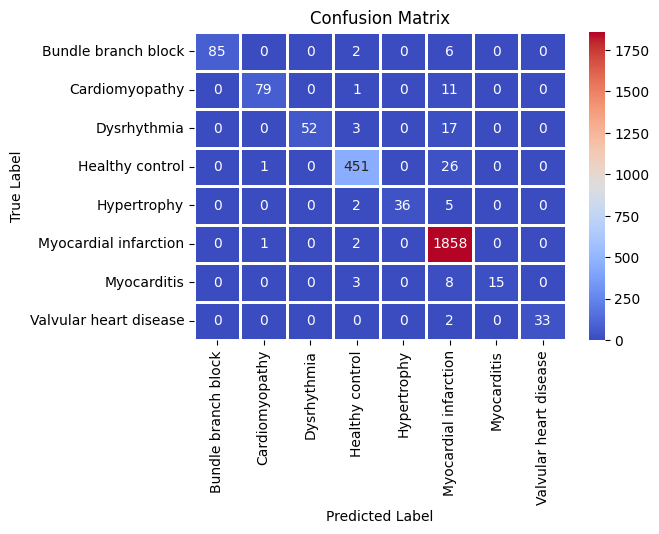

              precision    recall  f1-score   support

           0       1.00      0.91      0.96        93
           1       0.98      0.87      0.92        91
           2       1.00      0.72      0.84        72
           3       0.97      0.94      0.96       478
           4       1.00      0.84      0.91        43
           5       0.96      1.00      0.98      1861
           6       1.00      0.58      0.73        26
           7       1.00      0.94      0.97        35

    accuracy                           0.97      2699
   macro avg       0.99      0.85      0.91      2699
weighted avg       0.97      0.97      0.97      2699



In [124]:
print("RANDOM FOREST WITHOUT NN")
show_confusion_matrix(Y_test, rf_predictions)
print(classification_report(Y_test, rf_predictions))



RANDOM FOREST WITH NN


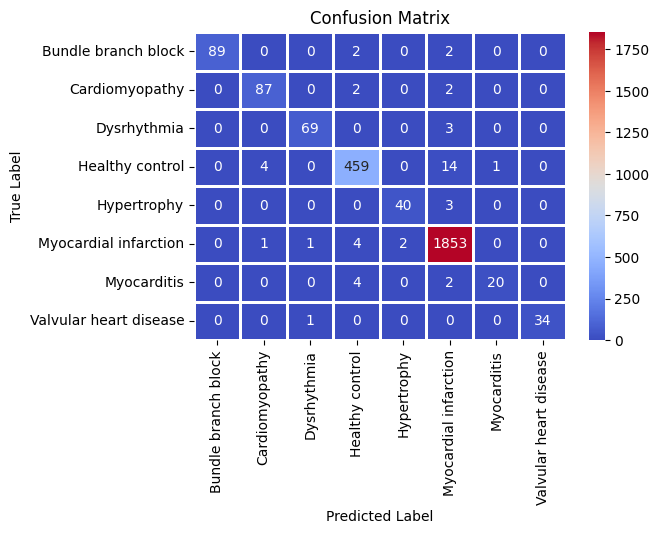

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        93
           1       0.95      0.96      0.95        91
           2       0.97      0.96      0.97        72
           3       0.97      0.96      0.97       478
           4       0.95      0.93      0.94        43
           5       0.99      1.00      0.99      1861
           6       0.95      0.77      0.85        26
           7       1.00      0.97      0.99        35

    accuracy                           0.98      2699
   macro avg       0.97      0.94      0.95      2699
weighted avg       0.98      0.98      0.98      2699



In [147]:
print("\n\nRANDOM FOREST WITH NN")
show_confusion_matrix(Y_test, rf_predictions_nn)
print(classification_report(Y_test, rf_predictions_nn))